# Corpus Handling

## before run this script, make sure you initiate submodule(dataset) by
```git submodule update```


### *original repository of dataset is (https://github.com/jungyeul/korean-parallel-corpora)*

In [1]:
import tarfile
tar_name = "./dataset/korean-english-news-v1/korean-english-park.train.tar.gz"

In [2]:
tar = tarfile.open(tar_name, "r:gz")
tar.extractall()
tar.close()

# Load Corpus and preprocessing

In [3]:
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from konlpy.tag import Mecab

mecab = Mecab()


In [4]:
corpus_en = open("korean-english-park.train.en", "r").read().splitlines()
corpus_ko = open("korean-english-park.train.ko", "r").read().splitlines()

In [5]:
def preprocess_kor(kl):
    """make preprocessed korean morpheme list from korean sentence
    Args:
        kl : korean sentence
    Return:
        preprocessed korean morpheme list
    """
    kl = kl.lower().strip()
    kl = re.sub(r'[" "]+', " ", kl)
    kl = re.sub(r"[^가-힣0-9?.!,¿]+", " ", kl)
    kl = kl.rstrip().strip()
    kl = mecab.morphs(kl)
    return kl

In [6]:
def preprocess_eng(el):
    """make preprocessed english word list from english sentence
    Args:
        el : english sentence
    Return:
        preprocessed english word list
    """
    el = el.lower().strip()
    el = re.sub(r'[" "]+', " ", el)
    el = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", el)
    el = el.rstrip().strip()
    el = word_tokenize(el)
    el = el + ["<EOS>"]
    return el

In [7]:
%%time
tokens_eng = list(map(preprocess_eng,corpus_en))                   
tokens_kor = list(map(preprocess_kor,corpus_ko))

CPU times: user 27.8 s, sys: 407 ms, total: 28.3 s
Wall time: 31.7 s


In [8]:
tokens_eng[0] , tokens_kor[0]

(['much',
  'of',
  'personal',
  'computing',
  'is',
  'about',
  'can',
  'you',
  'top',
  'this',
  '?',
  '<EOS>'],
 ['개인',
  '용',
  '컴퓨터',
  '사용',
  '의',
  '상당',
  '부분',
  '은',
  '이것',
  '보다',
  '뛰어날',
  '수',
  '있',
  '느냐',
  '?'])

# Make Vacabualry Dictionary

In [9]:
wordcnt_ko = defaultdict(lambda:0)
for text_kor in tqdm(tokens_kor):
    for tokens in text_kor:
        wordcnt_ko[tokens] +=1

100%|██████████| 94123/94123 [00:00<00:00, 216077.72it/s]


In [10]:
wordcnt_en = defaultdict(lambda:0)
for text_eng in tqdm(tokens_eng):
    for tokens in text_eng:
        wordcnt_en[tokens] +=1

100%|██████████| 94123/94123 [00:00<00:00, 237853.81it/s]


In [11]:
dict_kor = {k + 3: v for k,v in enumerate(wordcnt_ko.keys())}
dict_kor[0] = "<PAD>"
dict_kor[1] = "<UNK>"
dict_kor[2] = "<BOS>"

In [12]:
dict_kor_inv = {v:k for k,v in dict_kor.items()}

In [13]:
dict_kor_inv["<BOS>"]

2

In [14]:
dict_eng = {k + 4: v for k,v in enumerate(wordcnt_en.keys())}
dict_eng[0] = "<PAD>"
dict_eng[1] = "<UNK>"
dict_eng[2] = "<BOS>"
dict_eng[3] = "<EOS>"
dict_eng_inv = {v:k for k,v in dict_eng.items()}

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

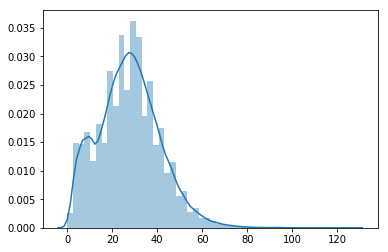

In [16]:
sns.distplot(list(map(len,tokens_kor)))

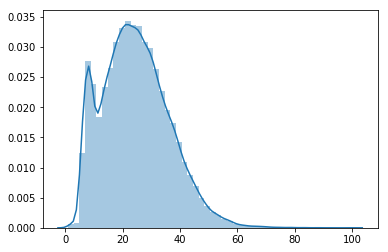

In [17]:
sns.distplot(list(map(len,tokens_eng)))

In [18]:
maxlen_kor = max(list(map(len,tokens_kor)))
maxlen_eng = max(list(map(len,tokens_eng))) + 1 # target language needs additional space for <BOS>
maxlen_kor, maxlen_eng

(127, 101)

# Transform Vocabulary to Index

In [19]:
def tokens2indexes_kor(tokens, maxlen=maxlen_kor):
    ret = np.zeros([maxlen], dtype=np.int32)
    for i in range(min(maxlen, len(tokens))):
        if tokens[i] in dict_kor_inv:
            ret[i] = dict_kor_inv[tokens[i]]
        else:
            ret[i] = dict_kor_inv["<UNK>"]
    return ret

In [20]:
array_kor = list(map(tokens2indexes_kor, tokens_kor))
array_kor = np.array(array_kor)

In [21]:
def tokens2indexes_eng(tokens, maxlen=maxlen_eng):
    ret = np.zeros([maxlen], dtype=np.int32)
    for i in range(min(maxlen, len(tokens))):
        if tokens[i] in dict_eng_inv:
            ret[i] = dict_eng_inv[tokens[i]]
        else:
            ret[i] = dict_eng_inv["<UNK>"]
    return ret

In [22]:
array_eng = list(map(tokens2indexes_eng, tokens_eng))
array_eng = np.array(array_eng)

In [23]:
array_eng

array([[   4,    5,    6, ...,    0,    0,    0],
       [  16,   17,   18, ...,    0,    0,    0],
       [  31,   32,   24, ...,    0,    0,    0],
       ...,
       [  34,   46, 2862, ...,    0,    0,    0],
       [1122,   68,  280, ...,    0,    0,    0],
       [1787,   69, 4162, ...,    0,    0,    0]], dtype=int32)

# Dataset Prepare

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_val, y_train, y_val = train_test_split(array_kor, array_eng, test_size=0.2, random_state=42)

# Model loading

In [26]:
import tensorflow as tf
tf.enable_eager_execution()

In [27]:
from transformer import Transformer
import modules

In [28]:
transformer_model = Transformer(100, 4, 0.5, maxlen_kor, maxlen_eng, len(dict_kor), len(dict_eng), 2, learning_rate=3e-3, device_name="gpu:0")

In [29]:
transformer_model(tf.convert_to_tensor(array_kor[:1]), tf.convert_to_tensor(array_eng[:1]), True)
transformer_model.summary(line_length=100, positions=[.70, .80, .90, 1.])

____________________________________________________________________________________________________
Layer (type)                                                          Output Sh Param #   
embedding_input (Embedding)                                           multiple  4391700   
____________________________________________________________________________________________________
embedding_target (Embedding)                                          multiple  4822900   
____________________________________________________________________________________________________
wrapped_attention_self_enc_0 (PrePostProcessingWrapper)               multiple  40200     
____________________________________________________________________________________________________
wrapped_attention_self_enc_1 (PrePostProcessingWrapper)               multiple  40200     
____________________________________________________________________________________________________
wrapped_ffn_enc_0 (PrePostProcessingWrap

In [30]:
# if you get OOM Error, try reduce batch_size
transformer_model.fit(X_train, y_train , X_val, y_val, bos_index=dict_eng_inv["<BOS>"], epochs=50, batch_size=32, tqdm_option="normal")

VAL    1: 100%|██████████| 589/589 [00:47<00:00,  2.52it/s]


[EPOCH 1 / STEP 1]
TRAIN loss   : 1.5746
VAL   loss   : 1.4774
saved step 1 in ckpt/


VAL    2: 100%|██████████| 589/589 [00:47<00:00,  2.56it/s]


[EPOCH 2 / STEP 2]
TRAIN loss   : 1.4199
VAL   loss   : 1.4229
saved step 2 in ckpt/


VAL    3: 100%|██████████| 589/589 [00:48<00:00,  2.56it/s]


[EPOCH 3 / STEP 3]
TRAIN loss   : 1.3578
VAL   loss   : 1.4103
saved step 3 in ckpt/


VAL    4: 100%|██████████| 589/589 [00:47<00:00,  2.51it/s]


[EPOCH 4 / STEP 4]
TRAIN loss   : 1.3202
VAL   loss   : 1.4028
saved step 4 in ckpt/


VAL    5: 100%|██████████| 589/589 [00:47<00:00,  2.54it/s]


[EPOCH 5 / STEP 5]
TRAIN loss   : 1.2951
VAL   loss   : 1.4003
saved step 5 in ckpt/


VAL    6: 100%|██████████| 589/589 [00:47<00:00,  2.52it/s]


[EPOCH 6 / STEP 6]
TRAIN loss   : 1.2758
VAL   loss   : 1.4039
saved step 6 in ckpt/


VAL    7: 100%|██████████| 589/589 [00:47<00:00,  2.53it/s]


[EPOCH 7 / STEP 7]
TRAIN loss   : 1.2608
VAL   loss   : 1.4064
saved step 7 in ckpt/


VAL    8: 100%|██████████| 589/589 [00:48<00:00,  2.56it/s]


[EPOCH 8 / STEP 8]
TRAIN loss   : 1.2485
VAL   loss   : 1.3925
saved step 8 in ckpt/


VAL    9: 100%|██████████| 589/589 [00:47<00:00,  2.54it/s]


[EPOCH 9 / STEP 9]
TRAIN loss   : 1.2387
VAL   loss   : 1.4089
saved step 9 in ckpt/


VAL   10: 100%|██████████| 589/589 [00:47<00:00,  2.53it/s]


[EPOCH 10 / STEP 10]
TRAIN loss   : 1.2299
VAL   loss   : 1.4045
saved step 10 in ckpt/


VAL   11: 100%|██████████| 589/589 [00:47<00:00,  2.50it/s]


[EPOCH 11 / STEP 11]
TRAIN loss   : 1.2220
VAL   loss   : 1.4003
saved step 11 in ckpt/


VAL   12: 100%|██████████| 589/589 [00:47<00:00,  2.52it/s]


[EPOCH 12 / STEP 12]
TRAIN loss   : 1.2144
VAL   loss   : 1.4016
saved step 12 in ckpt/


VAL   13: 100%|██████████| 589/589 [00:47<00:00,  2.54it/s]


[EPOCH 13 / STEP 13]
TRAIN loss   : 1.2077
VAL   loss   : 1.4080
saved step 13 in ckpt/


VAL   14: 100%|██████████| 589/589 [00:47<00:00,  2.52it/s]


[EPOCH 14 / STEP 14]
TRAIN loss   : 1.2019
VAL   loss   : 1.4004
saved step 14 in ckpt/


VAL   15: 100%|██████████| 589/589 [00:47<00:00,  2.53it/s]


[EPOCH 15 / STEP 15]
TRAIN loss   : 1.1963
VAL   loss   : 1.4073
saved step 15 in ckpt/


VAL   16: 100%|██████████| 589/589 [00:47<00:00,  2.51it/s]


[EPOCH 16 / STEP 16]
TRAIN loss   : 1.1906
VAL   loss   : 1.4128
saved step 16 in ckpt/


VAL   17: 100%|██████████| 589/589 [00:47<00:00,  2.52it/s]


[EPOCH 17 / STEP 17]
TRAIN loss   : 1.1855
VAL   loss   : 1.4081
saved step 17 in ckpt/


VAL   18: 100%|██████████| 589/589 [00:47<00:00,  2.54it/s]


[EPOCH 18 / STEP 18]
TRAIN loss   : 1.1814
VAL   loss   : 1.4035
saved step 18 in ckpt/


VAL   19: 100%|██████████| 589/589 [00:47<00:00,  2.48it/s]


[EPOCH 19 / STEP 19]
TRAIN loss   : 1.1770
VAL   loss   : 1.4065
saved step 19 in ckpt/


VAL   20: 100%|██████████| 589/589 [00:47<00:00,  2.53it/s]


[EPOCH 20 / STEP 20]
TRAIN loss   : 1.1728
VAL   loss   : 1.4153
saved step 20 in ckpt/


VAL   21: 100%|██████████| 589/589 [00:47<00:00,  2.51it/s]


[EPOCH 21 / STEP 21]
TRAIN loss   : 1.1693
VAL   loss   : 1.4051
saved step 21 in ckpt/


VAL   22: 100%|██████████| 589/589 [00:47<00:00,  2.50it/s]


[EPOCH 22 / STEP 22]
TRAIN loss   : 1.1653
VAL   loss   : 1.4157
saved step 22 in ckpt/


VAL   23: 100%|██████████| 589/589 [00:47<00:00,  2.57it/s]


[EPOCH 23 / STEP 23]
TRAIN loss   : 1.1627
VAL   loss   : 1.4110
saved step 23 in ckpt/


VAL   24: 100%|██████████| 589/589 [00:48<00:00,  2.07it/s]


[EPOCH 24 / STEP 24]
TRAIN loss   : 1.1594
VAL   loss   : 1.4154
saved step 24 in ckpt/


VAL   25: 100%|██████████| 589/589 [00:47<00:00,  2.50it/s]


[EPOCH 25 / STEP 25]
TRAIN loss   : 1.1563
VAL   loss   : 1.4200
saved step 25 in ckpt/


VAL   26: 100%|██████████| 589/589 [00:48<00:00,  2.26it/s]


[EPOCH 26 / STEP 26]
TRAIN loss   : 1.1542
VAL   loss   : 1.4213
saved step 26 in ckpt/


VAL   27: 100%|██████████| 589/589 [00:47<00:00,  2.51it/s]


[EPOCH 27 / STEP 27]
TRAIN loss   : 1.1528
VAL   loss   : 1.4245
saved step 27 in ckpt/


VAL   28: 100%|██████████| 589/589 [00:47<00:00,  2.50it/s]


[EPOCH 28 / STEP 28]
TRAIN loss   : 1.1496
VAL   loss   : 1.4166
saved step 28 in ckpt/


VAL   29: 100%|██████████| 589/589 [00:47<00:00,  2.49it/s]


[EPOCH 29 / STEP 29]
TRAIN loss   : 1.1477
VAL   loss   : 1.4123
saved step 29 in ckpt/


VAL   30: 100%|██████████| 589/589 [00:47<00:00,  2.55it/s]


[EPOCH 30 / STEP 30]
TRAIN loss   : 1.1452
VAL   loss   : 1.4192
saved step 30 in ckpt/


VAL   31: 100%|██████████| 589/589 [00:47<00:00,  2.48it/s]


[EPOCH 31 / STEP 31]
TRAIN loss   : 1.1433
VAL   loss   : 1.4240
saved step 31 in ckpt/


VAL   32: 100%|██████████| 589/589 [00:47<00:00,  2.33it/s]


[EPOCH 32 / STEP 32]
TRAIN loss   : 1.1422
VAL   loss   : 1.4193
saved step 32 in ckpt/


VAL   33: 100%|██████████| 589/589 [00:47<00:00,  2.51it/s]


[EPOCH 33 / STEP 33]
TRAIN loss   : 1.1396
VAL   loss   : 1.4182
saved step 33 in ckpt/


VAL   34: 100%|██████████| 589/589 [00:47<00:00,  2.54it/s]


[EPOCH 34 / STEP 34]
TRAIN loss   : 1.1384
VAL   loss   : 1.4273
saved step 34 in ckpt/


VAL   35: 100%|██████████| 589/589 [00:47<00:00,  2.50it/s]


[EPOCH 35 / STEP 35]
TRAIN loss   : 1.1369
VAL   loss   : 1.4241
saved step 35 in ckpt/


VAL   36: 100%|██████████| 589/589 [00:47<00:00,  2.54it/s]


[EPOCH 36 / STEP 36]
TRAIN loss   : 1.1364
VAL   loss   : 1.4207
saved step 36 in ckpt/


VAL   37: 100%|██████████| 589/589 [00:47<00:00,  2.55it/s]


[EPOCH 37 / STEP 37]
TRAIN loss   : 1.1354
VAL   loss   : 1.4205
saved step 37 in ckpt/


VAL   38: 100%|██████████| 589/589 [00:47<00:00,  2.49it/s]


[EPOCH 38 / STEP 38]
TRAIN loss   : 1.1338
VAL   loss   : 1.4176
saved step 38 in ckpt/


VAL   39: 100%|██████████| 589/589 [00:47<00:00,  2.25it/s]


[EPOCH 39 / STEP 39]
TRAIN loss   : 1.1327
VAL   loss   : 1.4263
saved step 39 in ckpt/


VAL   40: 100%|██████████| 589/589 [00:47<00:00,  2.49it/s]


[EPOCH 40 / STEP 40]
TRAIN loss   : 1.1321
VAL   loss   : 1.4217
saved step 40 in ckpt/


VAL   41: 100%|██████████| 589/589 [00:47<00:00,  2.54it/s]


[EPOCH 41 / STEP 41]
TRAIN loss   : 1.1318
VAL   loss   : 1.4152
saved step 41 in ckpt/


VAL   42: 100%|██████████| 589/589 [00:47<00:00,  2.50it/s]


[EPOCH 42 / STEP 42]
TRAIN loss   : 1.1311
VAL   loss   : 1.4198
saved step 42 in ckpt/


VAL   43: 100%|██████████| 589/589 [00:47<00:00,  2.50it/s]


[EPOCH 43 / STEP 43]
TRAIN loss   : 1.1296
VAL   loss   : 1.4225
saved step 43 in ckpt/


VAL   44: 100%|██████████| 589/589 [00:47<00:00,  2.54it/s]


[EPOCH 44 / STEP 44]
TRAIN loss   : 1.1282
VAL   loss   : 1.4199
saved step 44 in ckpt/


VAL   45: 100%|██████████| 589/589 [00:47<00:00,  2.54it/s]


[EPOCH 45 / STEP 45]
TRAIN loss   : 1.1278
VAL   loss   : 1.4169
saved step 45 in ckpt/


VAL   46: 100%|██████████| 589/589 [00:47<00:00,  2.48it/s]


[EPOCH 46 / STEP 46]
TRAIN loss   : 1.1267
VAL   loss   : 1.4215
saved step 46 in ckpt/


VAL   47: 100%|██████████| 589/589 [00:47<00:00,  2.49it/s]


[EPOCH 47 / STEP 47]
TRAIN loss   : 1.1260
VAL   loss   : 1.4180
saved step 47 in ckpt/


VAL   48: 100%|██████████| 589/589 [00:47<00:00,  2.50it/s]


[EPOCH 48 / STEP 48]
TRAIN loss   : 1.1256
VAL   loss   : 1.4258
saved step 48 in ckpt/


VAL   49: 100%|██████████| 589/589 [00:47<00:00,  2.49it/s]


[EPOCH 49 / STEP 49]
TRAIN loss   : 1.1255
VAL   loss   : 1.4218
saved step 49 in ckpt/


VAL   50: 100%|██████████| 589/589 [00:47<00:00,  2.54it/s]


[EPOCH 50 / STEP 50]
TRAIN loss   : 1.1253
VAL   loss   : 1.4245
saved step 50 in ckpt/


# inference

In [31]:
# start token for initial target tensor
start_token = tf.convert_to_tensor(np.expand_dims(tokens2indexes_eng(["<BOS>"]), 0))
start_token

<tf.Tensor: id=408047189, shape=(1, 101), dtype=int32, numpy=
array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

In [32]:
input_seq = X_train[1234:1235] # 1 batch
seq = input_seq[0]
[dict_kor[idx] for idx in seq]

['그',
 '는',
 '성명',
 '에서',
 '높',
 '은',
 '산모',
 '사망률',
 '과',
 '5',
 '세',
 '이하',
 '유아',
 '사망',
 '률',
 '은',
 '깨끗',
 '한',
 '물',
 ',',
 '공중',
 '위생',
 ',',
 '예방',
 '접종',
 ',',
 '적절',
 '한',
 '영양',
 '섭취',
 '등',
 '기본',
 '서비스',
 '접근',
 '이',
 '부족',
 '하',
 '다는',
 '것',
 '을',
 '가리킨다',
 '고',
 '말',
 '했',
 '다',
 '.',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',

In [33]:
# target answer
target_seq = y_train[1234:1235]
seq = target_seq[0]
" ".join([dict_eng[idx] for idx in seq])

'high maternal , infant and under five mortality often indicates lack of access to basic services such as clean water and sanitation , immunizations and proper nutrition , she said in a statement . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [34]:
input_seq = tf.convert_to_tensor(input_seq)

In [35]:
target_seq_shifted = tf.pad(target_seq, [[0, 0], [1, 0]], constant_values=dict_eng_inv["<BOS>"])[:, :-1]

In [36]:
# auto encoding check
logit = transformer_model(input_seq, target_seq_shifted, False)
indexes = tf.argmax(logit, axis=2).numpy()[0]
" ".join([dict_eng[idx] for idx in indexes])

'he school , infant and ill the mortality often indicates lack of health to food services in as chemical drinking and sanitation , thus and proper nutrition , she said . a statement . <EOS> , her her and , , , , , . , , , , . . . . . . , . . . . , . . , of said said said that said to for said said , . . , said in in in . . . . in vehicles efficiency enrollment in in in in in in in amount amount plunged in'

In [37]:
# beam search(inference only by input sequence)
beams = transformer_model.predict(input_seq, start_token, dict_eng_inv["<EOS>"], beam_cnt=3)


In [38]:
for prob, beam in beams:
    seq = beam.numpy()[0]
    print(" ".join([dict_eng[idx] for idx in seq if not (idx ==2 or idx==0 or idx ==3)]))
    print()

he said that the number of patients who have died in more than a year ago , he said in a written statement .

he said that the number of patients who have died in more than a year ago , he said in a statement from the united states , he said .

he said that the number of patients who have died in more than a year ago , he said in a statement from the united states , he said in a statement .

he said that the number of patients who have died in more than a year ago , he said in a statement from the united states , he said , a spokesman for the health .

he said that the number of patients who have died in more than a year ago , he said in a statement from the united states , he said , a spokesman for the united states .

he said that the number of patients who have died in more than a year ago , he said in a statement from the united states , he said , a spokesman for the united states , he said .

he said that the number of patients who have died in more than a year ago , he said in a 

## if you want to make inference to other example on trainset...

In [110]:
i = 1464  # train data number

In [111]:
input_seq = X_train[i:i+1] # 1 batch
seq = input_seq[0]
[dict_kor[idx] for idx in seq]

['경제',
 '부총리',
 '이',
 '기',
 '도',
 '한',
 '이헌재',
 '장관',
 '은',
 '비난',
 '여론',
 '이',
 '정부',
 '의',
 '신용도',
 '에',
 '악영향',
 '을',
 '미쳐',
 '사퇴',
 '한다고',
 '말',
 '했',
 '다',
 '.',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<

In [112]:
# target answer
target_seq = y_train[i:i+1]
seq = target_seq[0]
" ".join([dict_eng[idx] for idx in seq])

'lee , who is also the deputy prime minister , said he was stepping down because the controversy was damaging the credibility of the government . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [113]:
input_seq = tf.convert_to_tensor(input_seq)

In [114]:
target_seq_shifted = tf.pad(target_seq, [[0, 0], [1, 0]], constant_values=dict_eng_inv["<BOS>"])[:, :-1]

In [115]:
# auto encoding check
logit = transformer_model(input_seq, target_seq_shifted, False)
indexes = tf.argmax(logit, axis=2).numpy()[0]
" ".join([dict_eng[idx] for idx in indexes])

'the myung who has the expected opposition cabinet minister of said he would not down in of economy was not the economy of the opposition . <EOS> is is is , , , , , , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . in in in . . . . . . . in in in in in in in in in in in in'

In [116]:
# beam search(inference only by input sequence)
beams = transformer_model.predict(input_seq, start_token, dict_eng_inv["<EOS>"], beam_cnt=3)
for prob, beam in beams:
    seq = beam.numpy()[0]
    print(" ".join([dict_eng[idx] for idx in seq if not (idx ==2 or idx==0 or idx ==3)]))
    print()

president roh moo hyun said yesterday that the government has expressed concern over the financial crisis .

president roh moo hyun said yesterday that the government has expressed concern over the economic crisis .

president roh moo hyun said yesterday that the government has expressed concern over the opposition to the opposition .

president roh moo hyun said yesterday that the government has expressed concern over the opposition to the opposition party .

president roh moo hyun said yesterday that the government has expressed concern over the opposition to the opposition party s presidential nomination .

president roh moo hyun said yesterday that the government has expressed concern over the opposition to the opposition party s presidential election .

president roh moo hyun said yesterday that the government has expressed concern over the opposition to the opposition party s presidential election commission .

president roh moo hyun said yesterday that the government has express